# Neural Networks implementation

In this notebook, we will implement the feedforward neural networks with backpropagation algorithm for both online and batch training. 

I built this notebook to study for the Neural Networks class of my Masters Degree Course.

We will use only numpy, python base functions and sickit's dataset generator.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

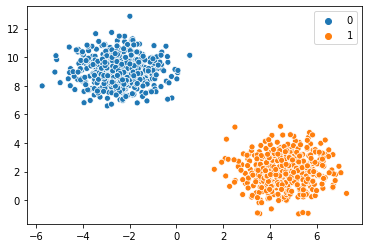

In [3]:
# generating points to use on training
seed = 42
np.random.seed(seed)
X, y = make_blobs(n_samples=1024, centers=2, n_features=2)
sns.scatterplot(X[:, 0], X[:, 1], hue=y)
plt.show()

[ 0.0498      0.04997698 -0.04979354]
0.9970703125


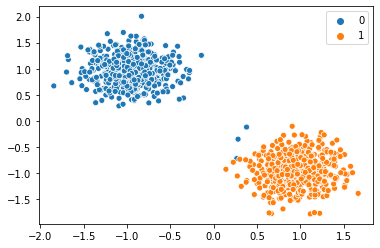

In [4]:
def logistic(x):
    y_pred_labels = lambda y_pred: 1 if y_pred >= 0.5 else 0
    y = 1/(1+np.exp(-x))
    return y_pred_labels(y)
def tansig(x):
    return (1-np.exp(-x))/(1+np.exp(-x))
def relu(x):
    return max(0, x)
def step(x):
    return 0 if x < 0 else 1    

def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

class Perceptron:
    '''
    Implementation of single unity of a MLP with the perceptron implementation.
    '''

    def __init__(self, activation=step, solver="online",
                 eta0=0.01, seed=None,
                 epochs=1):
        np.random.seed(seed)
        self._activation = activation
        self._solver = str(solver)
        self._weights = None
        self._eta0 = eta0
        self.epochs = epochs
    def fit(self, X, y):
        size_input = X.shape[1] + 1
        size_samples = X.shape[0]
        self._weights = np.zeros(size_input)
        input_bias = -1 * np.ones((size_samples, size_input))
        input_bias[:, 1:] = X
        error = 1
        for j in range(self.epochs):            
            for i in range(size_samples):
                output = np.sum(self._weights*input_bias[i, :])
                output_activated = self._activation(output)
                error = y[i] - output
                new_weights = self._weights + self._eta0*error*input_bias[i, :]
                self._weights = new_weights
            input_bias, y = shuffle_in_unison(input_bias, y)
        return self
    def predict(self, X):
        size_input = X.shape[1] + 1
        size_samples = X.shape[0]
        input_bias = -1 * np.ones((size_samples, size_input))
        input_bias[:, 1:] = X
        inducted = self._weights @ input_bias.transpose()
        output = np.array(list(map(self._activation, inducted)))
        return output
    def fit_predict(self, X, y):
        return self.fit(X, y).predict(X)
    def batch_fit(self, X, y):
        size_input = X.shape[1] + 1
        size_samples = X.shape[0]
        self._weights = np.zeros(size_input)
        input_bias = -1 * np.ones((size_samples, size_input))
        input_bias[:, 1:] = X
        error = 1
        for j in range(self.epochs):
            output_array = input_bias @ self._weights.transpose()
            output_array = np.array(list(map(self._activation, output_array)))
            error_array = y - output_array
            mean_error_array = np.mean(error_array)
            new_weights = self._weights + self._eta0*(error_array @ input_bias)
            #print((self._eta0*(error_array @ input_bias)).shape)
            self._weights = new_weights
            input_bias, y = shuffle_in_unison(input_bias, y)
        return self
    
    

    
scaler = StandardScaler()
X = scaler.fit_transform(X)
perceptron = Perceptron(epochs=4, eta0 = 0.0001, seed=36, activation=logistic)
perceptron.batch_fit(X, y)
y_pred = perceptron.predict(X)
print(perceptron._weights)
print(accuracy_score(y, y_pred))
sns.scatterplot(X[:, 0], X[:, 1], hue=y_pred)
plt.show()
#print(perceptron._weights)

#perceptron.fit(X, y)
#print(perceptron._weights)
#y_pred = perceptron.fit_predict(X, y)

#print(accuracy_score(y, y_pred))
#sns.scatterplot(X[:, 0], X[:, 1], hue=y_pred)
#plt.show()

In [5]:
y_pred_labels = lambda y_pred: 1 if y_pred >= 0.5 else 0
y_pred_final = np.array(list(map(y_pred_labels, y_pred)))
print(accuracy_score(y, y_pred_final))

0.9970703125


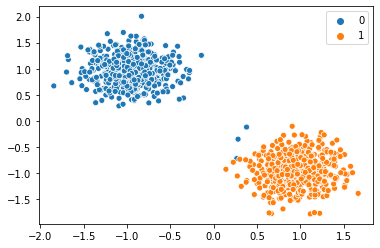

In [6]:
sns.scatterplot(X[:, 0], X[:, 1], hue=y_pred)

## Implementing MLP

The after finishing batch training for a single perceptron, now it's time for making an MLP class with a bunch of perceptrons that we've implemented.

In [7]:
'''
def logistic(x):
    y = 1/(1+np.exp(-x))
    return y
def dlogistic(x):
    return logistic(x)*(1-logistic(x))
def tansig(x):
    return (1-np.exp(-x))/(1+np.exp(-x))
def relu(x):
    return max(0, x)
def step(x):
    return 0 if x < 0 else 1

class MultilayerPerceptron:
    def __init__(self, hidden_layer_sizes=(2, 2),
                 activation=logistic, solver="online",
                 eta0=0.0001, seed=None,
                 epochs=1 ):
        self._hidden_layer_sizes = hidden_layer_sizes
        self._activation = activation
        self._eta0 = eta0
        self._epochs = epochs
        self._weights = None
        np.random.seed(seed)
    def fit(self, X, y):
        size_input = X.shape[1]+1
        size_samples = X.shape[0]
        input_bias = -1 * np.ones((size_samples, size_input))
        input_bias[:, 1:] = X
        self.initialize_weights(input_bias)
        for epoch in range(self._epochs):
            for i, value_out in enumerate(y):
                y_pred = self.feedforward(input_bias[i])
                self.backpropagation(y, y_pred)
        
    def initialize_weights(self, X):
        size_input = X.shape[1]
        size_samples = X.shape[0]
        weights = []
        for j, layer_size in enumerate(self._hidden_layer_sizes):
            layer_weights = []
            for i in range(layer_size):                
                if j == 0:
                    layer_weights.append(np.zeros(size_input))
                else:
                    layer_size_plus_bias = self._hidden_layer_sizes[j-1] + 1
                    layer_weights.append(np.zeros(layer_size_plus_bias))
            weights.append(layer_weights)
        output_layer_weights = np.zeros(len(weights[-1])+1)
        weights.append(output_layer_weights)
        self._weights = weights
    
    def feedforward(self, X):
        for i, layer_weights in enumerate(self._weights):
            
            if i == 0:
                next_input = []
                for j in layer_weights:
                    stimulation = X @ j.transpose()
                    next_input.append(self._activation(stimulation))            
            elif i < len(self._hidden_layer_sizes):
                size_input = len(next_input) + 1
                size_samples = 1
                input_bias = -1 * np.ones(size_input)
                input_bias[1:] = next_input                
                next_input = []
                for j in layer_weights:
                    stimulation = input_bias @ j.transpose()
                    next_input.append(self._activation(stimulation))                
            else:
                size_input = len(next_input) + 1
                input_bias = -1 * np.ones(size_input)
                input_bias[1:] = next_input
                output1 = input_bias @ layer_weights.transpose()
                output = self._activation(output1)
        return output
    def backpropagation(self, y_true, y_pred):
        error = y_true - y_pred
        gradient = error*dlogistic()
        
mlp = MultilayerPerceptron(seed=333, hidden_layer_sizes=(3,3,3,3,3,3), activation=logistic)
mlp.fit(X, y)
'''
print()

# Building Multilayer Perceptron with 3 layers

First, we are going to code a neural network based on Daniel Shiffman's video on coding train, but using Python to code.

In this code, we are going to build a 3 layer perceptron, with input layer, hidden layer and output layer.

The accuracy of the model is: 100.0


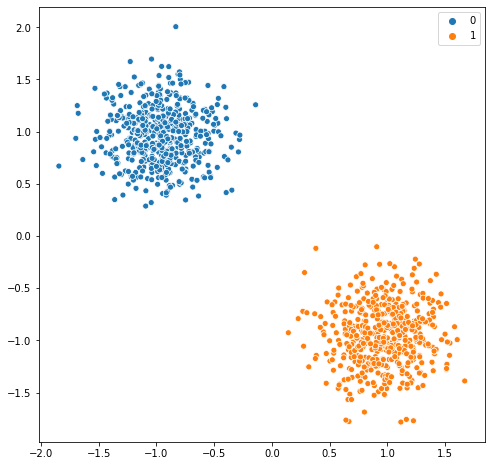

In [8]:
import math
def sigmoid(x):
    return 1/(1+np.exp(-x))
def dsigmoid(x):
    return x * (1 - x)
class NeuralNetwork:
    def __init__(self, inputLayer=2, hiddenLayer=2, outputLayer=1, learningRate=0.0001):
        np.random.seed(42)
        self.inputLayer = inputLayer
        self.hiddenLayer = hiddenLayer
        self.outputLayer = outputLayer
        self.weights_ih = np.random.random((hiddenLayer, inputLayer)) * 2 - 1
        self.weights_ho = np.random.random((outputLayer, hiddenLayer)) * 2 - 1
        
        self.bias_h = np.random.random((hiddenLayer)) * 2 - 1
        self.bias_o = np.random.random((outputLayer)) * 2 - 1

        self.learningRate = learningRate
    def feedforward(self, input):
        #Generating the hidden outputs
        hidden = self.weights_ih @ input
        hidden += self.bias_h
        #Activation function
        hidden = sigmoid(hidden)
        
        #Generating the outputs on last layer
        output = self.weights_ho @ hidden
        output += self.bias_o
        output = sigmoid(output)

        #Sending back to the caller
        return output
    
    def train(self, inputs, targets):
         #Generating the hidden outputs
        hidden = self.weights_ih @ inputs
        hidden += self.bias_h
        #Activation function
        hidden = sigmoid(hidden)
        
        #Generating the outputs on last layer
        outputs = self.weights_ho @ hidden
        outputs += self.bias_o
        outputs = sigmoid(outputs)

        #Calculate the error
        output_errors = targets - outputs
        
        #Calculate hidden gradient
        gradients = dsigmoid(outputs)
        gradients = gradients * output_errors
        gradients *= self.learningRate

        #Adjusting dimensions to fit multiplication matrices
        #gradients = gradients.reshape(1, self.outputLayer)
        #hidden_T = hidden.reshape(1, self.hiddenLayer)

        #Updating hidden to output weights
        weights_ho_deltas = hidden * gradients
        self.weights_ho += weights_ho_deltas
        self.bias_o += gradients

        #calculating hidden errors
        who_t = self.weights_ho.transpose()
        hidden_errors = who_t @ output_errors

        #Calculating Hidden Gradient
        hidden_gradient = dsigmoid(hidden)
        hidden_gradient = hidden_gradient @ hidden_errors
        hidden_gradient *= self.learningRate

        #Updating input to hidden weights
        inputs_T = inputs.transpose()
        weights_ih_deltas = hidden_gradient * inputs_T
        self.weights_ih += weights_ih_deltas
        self.bias_h += hidden_gradient
    def fit(self, X, y):
        for i, value in enumerate(X):
            self.train(value, y[i])
        return self

nn = NeuralNetwork(2, 1, 1, learningRate=0.1)
samples = np.random.uniform(low=-10, high=10, size=50).reshape((25, 2))
nn.fit(X, y)
y_pred = []
for sample in X:    
    y_pred.append(nn.feedforward(sample))
y_pred_array = np.array(y_pred)
y_pred_array = y_pred_array >= 0.5
y_pred_array = np.array(y_pred_array, dtype=int)
print(f"The accuracy of the model is: {accuracy_score(y, y_pred_array) * 100}")

plt.figure(figsize=(8, 8))
sns.scatterplot(X[:, 0], X[:, 1], hue=y_pred_array[:, 0])
plt.show()